# TESS Atlas fit for TOI 2440

**Version: '0.2.1.dev30+g4180b55.d20210911'**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 2440.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/gh-pages/notebooks/'0.2.1.dev30+g4180b55.d20210911'/toi-2440.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/gh-pages/notebooks/'0.2.1.dev30+g4180b55.d20210911'/toi-2440.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/gh-pages/notebooks/'0.2.1.dev30+g4180b55.d20210911'/toi-2440.ipynb).



## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously.

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Downloading Data](#Downloading-Data)
3. [Fitting stellar parameters](#Fitting-stellar-parameters)
4. [Results](#Results)
5. [Citations](#Citations)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline:

In [1]:
%matplotlib inline

Then we'll set up the plotting styles and do all of the imports:

In [2]:

import logging
import os

import exoplanet as xo
import numpy as np
import pandas as pd
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
from celerite2.theano import GaussianProcess, terms
from pymc3.sampling import MultiTrace

from tess_atlas.data import TICEntry
from tess_atlas.analysis.eccenticity_reweighting import (
    calculate_eccentricity_weights,
)

from tess_atlas.utils import notebook_initalisations
from tess_atlas.utils import NOTEBOOK_LOGGER_NAME

notebook_initalisations()
logger = logging.getLogger(NOTEBOOK_LOGGER_NAME)

In [3]:
os.environ["INTERACTIVE_PLOTS"] = "FALSE"  # "TRUE" for interactive plots
from tess_atlas.plotting import (
    plot_eccentricity_posteriors,
    plot_folded_lightcurve,
    plot_phase,
    plot_lightcurve,
    plot_posteriors,
)

In [4]:
TOI_NUMBER = 2440

## Downloading Data

Next, we grab some inital guesses for the TOI's parameters from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) and download the TOI's lightcurve with [Lightkurve].

We wrap the information in three objects, a `TIC Entry`, a `Planet Candidate` and finally a `Lightcurve Data` object.

- The `TIC Entry` object holds one or more `Planet Candidate`s (each candidate associated with one TOI id number) and a `Lightcurve Data` for associated with the candidates. Note that the `Lightcurve Data` object is initially the same fopr each candidate but may be masked according to the candidate transit's period.

- The `Planet Candidate` holds informaiton on the TOI data collected by [SPOC] (eg transit period, etc)

- The `Lightcurve Data` holds the lightcurve time and flux data for the planet candidates.

[ExoFOP]: https://exofop.ipac.caltech.edu/tess/
[Lightkurve]: https://docs.lightkurve.org/index.html
[SPOC]: https://heasarc.gsfc.nasa.gov/docs/tess/pipeline.html

Downloading the data (this may take a few minutes):

In [5]:
tic_entry = TICEntry.generate_tic_from_toi_number(toi=TOI_NUMBER)


2021-09-11 20:24:25,035 - TESS-ATLAS - INFO - Searching for lightkurve data with target='TIC 129839175', mission='TESS'


2021-09-11 20:24:27,047 - TESS-ATLAS - INFO - Downloading 1 observations of light curve data (TIC 129839175)


2021-09-11 20:24:31,294 - TESS-ATLAS - INFO - Completed light curve data download


2021-09-11 20:24:31,551 - TESS-ATLAS - INFO - Saved lightcurve data.


The initial guesses for the parameters (determined by SPOC):

In [6]:
tic_entry.display()


TOI,2440.01
TOI,2440.01
Period (days),0.646157
Epoch (TBJD),2144.98
Depth (ppt),6.29062
Duration (days),0.0498493
Single Transit,False


Plot of the lightcurve:

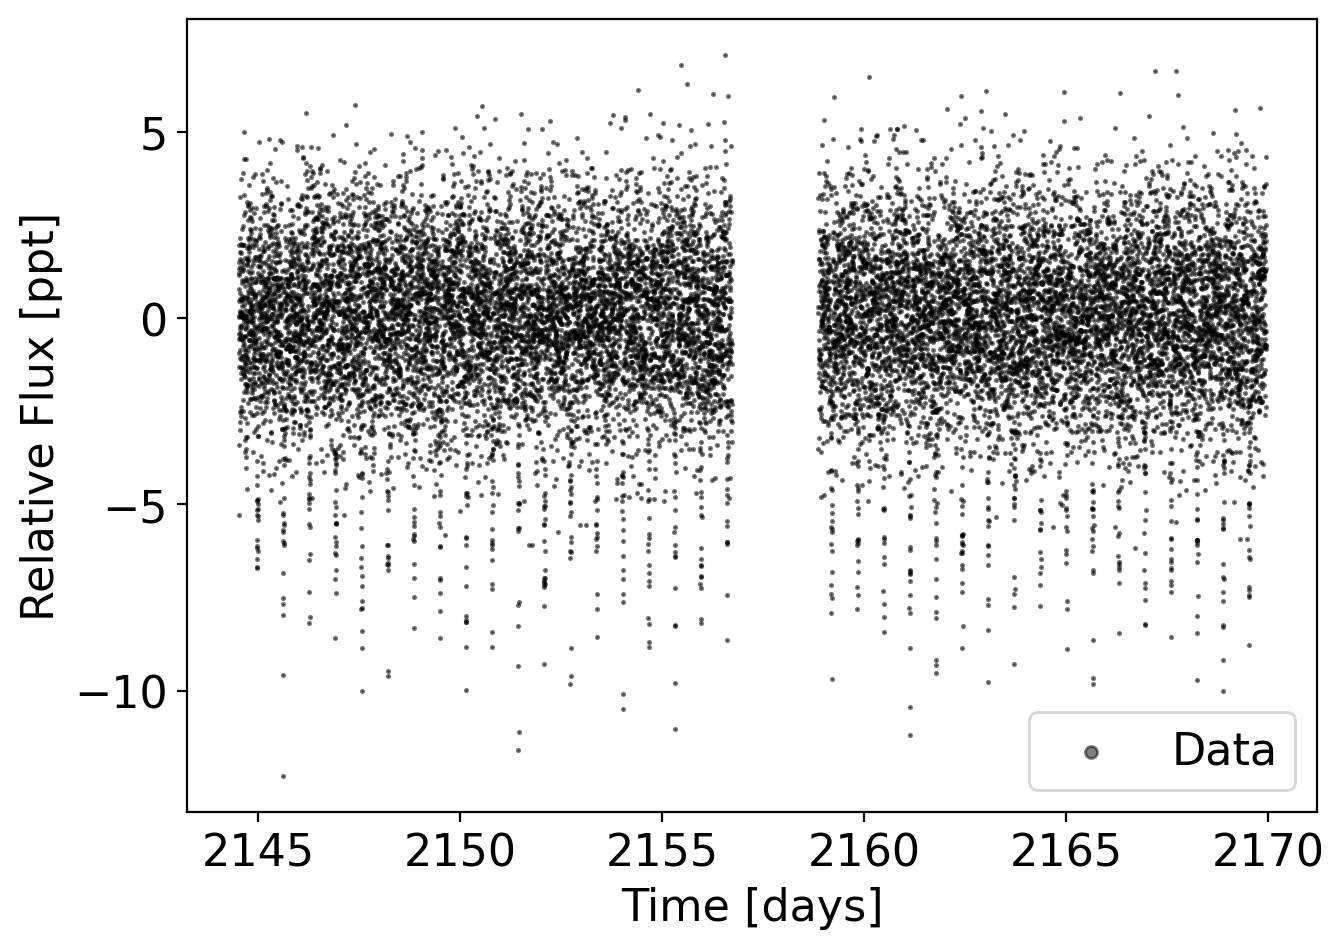

In [7]:
plot_lightcurve(tic_entry)

## Fitting stellar parameters
Now that we have the data, we can define a Bayesian model to fit it.

### The probabilistic model

We use the probabilistic model as described in [Foreman-Mackey et al 2017] to determine the best parameters to fit the transits present in the lightcurve data.

More explicitly, the stellar light curve $l(t; \vec{\theta})$ is modelled with a Gaussian Process (GP).
A GP consists of a mean function $\mu(t;\vec{\theta})$ and a kernel function $k_\alpha(t,t';\vec{\theta})$, where $\vec{\theta}$ is the vector of parameters descibing the lightcurve and $t$ is the time during which the lightcurve is under observation

The 8 parameters describing the lightcurve are
$$\vec{\theta} = \{d_i, t0_i, tmax_i, b_i, r_i, f0, u1, u2\},$$
where
* $d_i$ transit durations for each planet,
* $t0_i$ transit phase/epoch for each planet,
* $tmax_i$ time of the last transit observed by TESS for each planet,
* $b_i$ impact parameter for each planet,
* $r_i$ planet radius in stellar radius for each planet,
* $f0$ baseline relative flux of the light curve from star,
* $u1$ $u2$ two parameters describing the limb-darkening profile of star.

Note: if the observed data only records a single transit,
we swap $tmax_i$ with $p_i$ (orbital periods for each planet).

With this we can write
$$l(t;\vec{\theta}) \sim \mathcal{GP} (\mu(t;\vec{\theta}), k_\alpha(t,t';\vec{\theta}))\ .$$

Here the mean and kernel functions are:
* $\mu(t;\vec{\theta})$: a limb-darkened transit light curve ([Kipping 2013])
* $k_\alpha(t,t';\vec{\theta}))$: a stochastically-driven, damped harmonic oscillator ([SHOTterm])


Now that we have defined our transit model, we can implement it in python:

[Foreman-Mackey et al 2017]: https://arxiv.org/pdf/1703.09710.pdf
[Kipping 2013]: https://arxiv.org/abs/1308.0009
[SHOTterm]: https://celerite2.readthedocs.io/en/latest/api/python/?highlight=SHOTerm#celerite2.terms.SHOTerm

In [8]:
def build_planet_transit_model(tic_entry):

    # TODO: update model https://github.com/exoplanet-dev/tess.world/blob/main/src/tess_world/templates/template.py#L305
    t = tic_entry.lightcurve.time
    y = tic_entry.lightcurve.flux
    yerr = tic_entry.lightcurve.flux_err

    n = tic_entry.planet_count
    t0s = np.array([planet.t0 for planet in tic_entry.candidates])
    depths = np.array([planet.depth for planet in tic_entry.candidates])
    periods = np.array([planet.period for planet in tic_entry.candidates])
    tmaxs = np.array([planet.tmax for planet in tic_entry.candidates])
    durations = np.array([planet.duration for planet in tic_entry.candidates])
    max_duration, min_duration = durations.max(), durations.min()

    with pm.Model() as my_planet_transit_model:
        ## define planet 𝜃⃗
        d_priors = pm.Lognormal("d", mu=np.log(0.1), sigma=10.0, shape=n)
        r_priors = pm.Lognormal(
            "r", mu=0.5 * np.log(depths * 1e-3), sd=1.0, shape=n
        )
        b_priors = xo.distributions.ImpactParameter("b", ror=r_priors, shape=n)
        planet_priors = [r_priors, d_priors, b_priors]

        ## define orbit-timing 𝜃⃗
        t0_norm = pm.Bound(
            pm.Normal, lower=t0s - max_duration, upper=t0s + max_duration
        )
        t0_priors = t0_norm("t0", mu=t0s, sd=1.0, shape=n)

        p_params, p_priors_list, tmax_priors_list = [], [], []
        for n, planet in enumerate(tic_entry.candidates):
            if planet.has_data_only_for_single_transit:
                p_prior = pm.Pareto(
                    f"p_{planet.index}",
                    m=planet.period_min,
                    alpha=2.0 / 3.0,
                    testval=planet.period,
                )
                p_param = p_prior
                tmax_prior = planet.t0
            else:
                tmax_norm = pm.Bound(
                    pm.Normal,
                    lower=planet.tmax - max_duration,
                    upper=planet.tmax + max_duration,
                )
                tmax_prior = tmax_norm(
                    f"tmax_{planet.index}",
                    mu=planet.tmax,
                    sigma=0.5 * planet.duration,
                    testval=planet.tmax,
                )
                p_prior = (tmax_prior - t0_priors[n]) / planet.num_periods
                p_param = tmax_prior

            p_params.append(p_param)  # the param needed to calculate p
            p_priors_list.append(p_prior)
            tmax_priors_list.append(tmax_prior)

        p_priors = pm.Deterministic("p", tt.stack(p_priors_list))
        tmax_priors = pm.Deterministic("tmax", tt.stack(tmax_priors_list))

        ## define stellar 𝜃⃗
        f0_prior = pm.Normal("f0", mu=0.0, sd=10.0)
        u_prior = xo.distributions.QuadLimbDark("u")
        stellar_priors = [f0_prior, u_prior]

        ## define 𝑘(𝑡,𝑡′;𝜃⃗ )
        jitter_prior = pm.InverseGamma(
            "jitter", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        sigma_prior = pm.InverseGamma(
            "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        rho_prior = pm.InverseGamma(
            "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 10.0)
        )
        kernel = terms.SHOTerm(sigma=sigma_prior, rho=rho_prior, Q=0.3)
        noise_priors = [jitter_prior, sigma_prior, rho_prior]

        ## define 𝜇(𝑡;𝜃) (the lightcurve model)
        orbit = xo.orbits.KeplerianOrbit(
            period=p_priors,
            t0=t0_priors,
            b=b_priors,
            duration=d_priors,
            ror=r_priors,
        )
        star = xo.LimbDarkLightCurve(u_prior)
        lightcurve_models = star.get_light_curve(orbit=orbit, r=r_priors, t=t)
        lightcurve = 1e3 * pm.math.sum(lightcurve_models, axis=-1) + f0_prior
        lightcurve_models = pm.Deterministic("lightcurves", lightcurve_models)
        rho_circ = pm.Deterministic("rho_circ", orbit.rho_star)

        # Finally the GP observation model
        residual = y - lightcurve
        gp = GaussianProcess(
            kernel, t=t, diag=yerr ** 2 + jitter_prior ** 2, mean=lightcurve
        )
        gp.marginal("obs", observed=y)

        # cache params
        my_params = dict(
            planet_params=planet_priors,
            noise_params=noise_priors,
            stellar_params=stellar_priors,
            period_params=p_params,
        )
    return my_planet_transit_model, my_params, gp


def test_model(model):
    """Test a point in the model and assure no nans"""
    with model:
        test_prob = model.check_test_point()
        test_prob.name = "log P(test-point)"
        assert not test_prob.isnull().values.any(), test_prob
        test_pt = pd.Series(
            {
                k: str(round(np.array(v).flatten()[0], 2))
                for k, v in model.test_point.items()
            },
            name="Test Point",
        )
        return pd.concat([test_pt, test_prob], axis=1)

In [9]:
planet_transit_model, params, gp = build_planet_transit_model(tic_entry)
test_model(planet_transit_model)

,Test Point,log P(test-point)
d_log__,-2.3,-3.22
r_log__,-2.53,-0.92
b_impact__,-0.15,-1.39
t0_interval__,0.0,-4.61
tmax_1_interval__,0.0,-0.92
f0,0.0,-3.22
u_quadlimbdark__,0.0,-2.77
jitter_log__,0.56,0.11
sigma_log__,0.56,0.11
rho_log__,0.05,-0.55


The test point acts as an example of a point in the parameter space.
We can now optimize the model sampling parameters before initialising the sampler.

In [10]:
def get_optimized_init_params(
    model, planet_params, noise_params, stellar_params, period_params
):
    """Get params with maximimal log prob for sampling starting point"""
    logger.info("Optimizing sampling starting point")
    with model:
        theta = model.test_point
        kwargs = dict(start=theta, verbose=False, progress=False)
        theta = pmx.optimize(**kwargs, vars=[noise_params[0]])
        theta = pmx.optimize(**kwargs, vars=planet_params)
        theta = pmx.optimize(**kwargs, vars=noise_params)
        theta = pmx.optimize(**kwargs, vars=stellar_params)
        theta = pmx.optimize(**kwargs, vars=period_params)
    logger.info("Optimization complete!")
    return theta

In [11]:
init_params = get_optimized_init_params(planet_transit_model, **params)

2021-09-11 20:24:51,208 - TESS-ATLAS - INFO - Optimizing sampling starting point


INFO:TESS-ATLAS:Optimizing sampling starting point


2021-09-11 20:25:37,031 - TESS-ATLAS - INFO - Optimization complete!


INFO:TESS-ATLAS:Optimization complete!


Now we can plot our initial model:

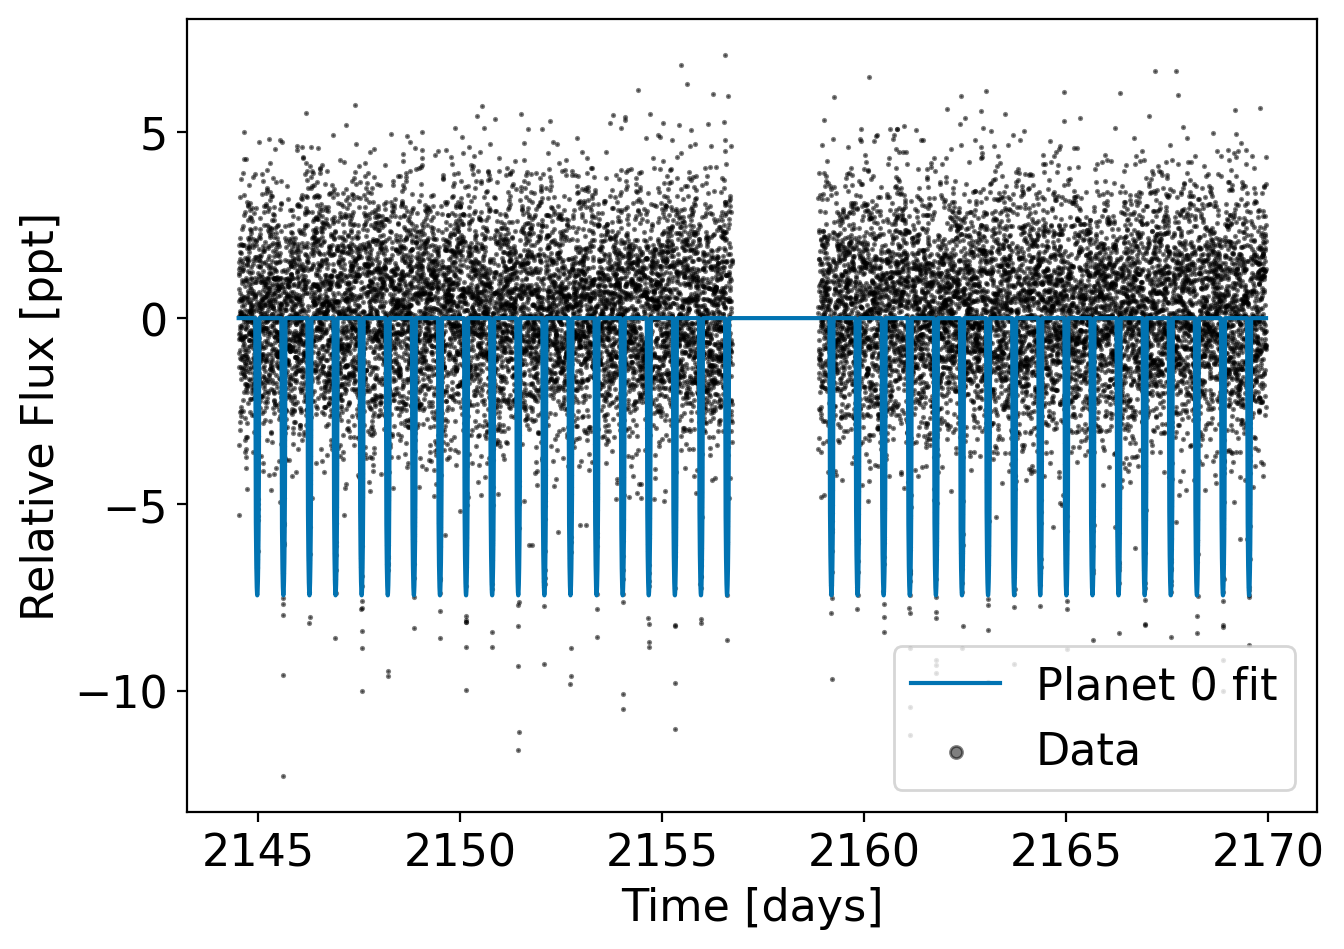

In [12]:
model_lightcurves = [
    init_params["lightcurves"][:, i] * 1e3
    for i in range(tic_entry.planet_count)
]
plot_lightcurve(tic_entry, model_lightcurves)

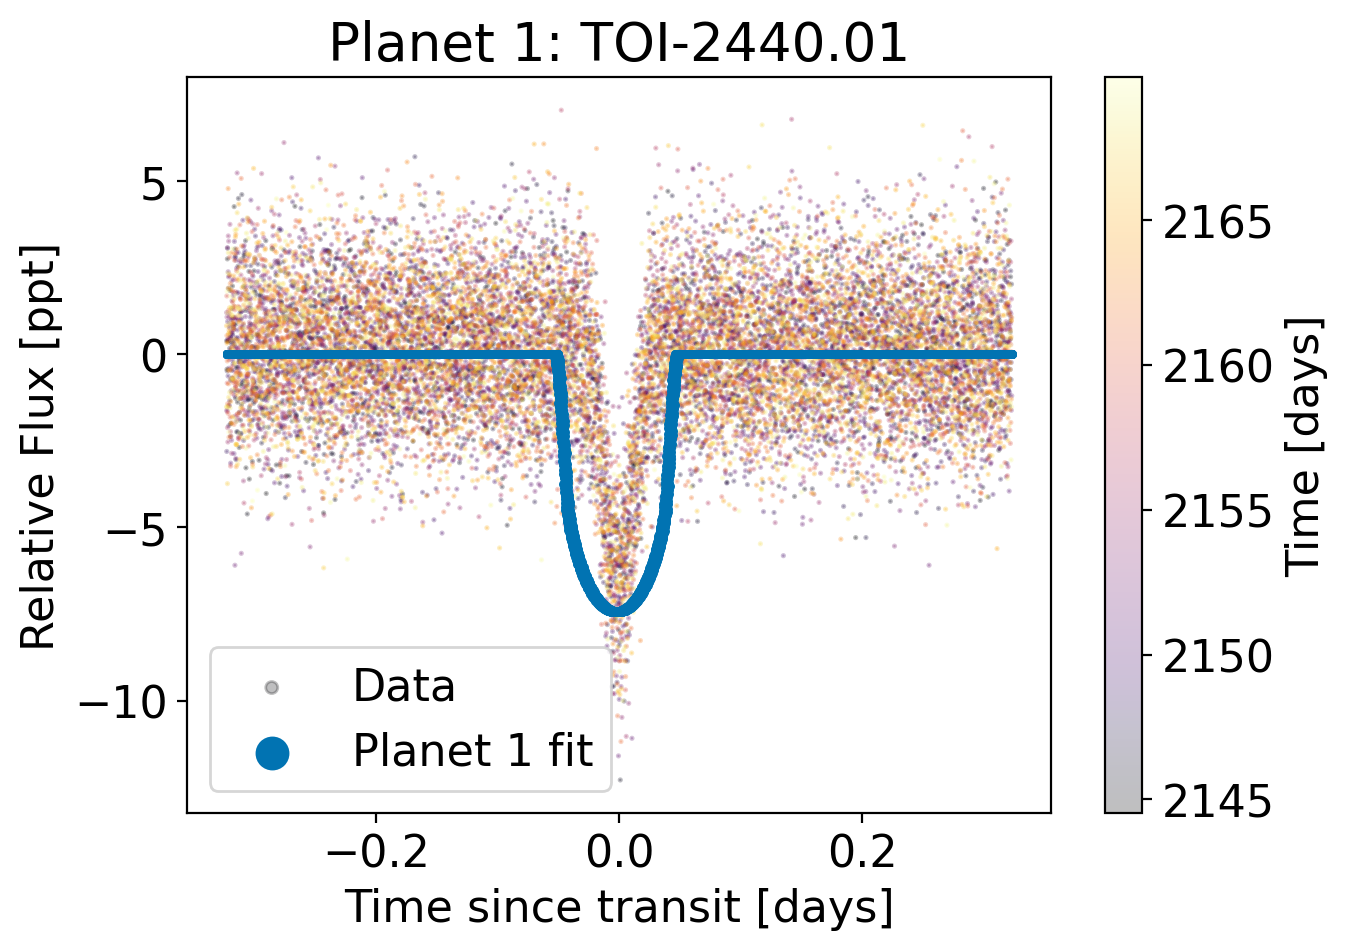

In [13]:
plot_folded_lightcurve(tic_entry, model_lightcurves)



### Sampling
With the model and priors defined, we can begin sampling

In [14]:
def start_model_sampling(model) -> MultiTrace:
    np.random.seed(TOI_NUMBER)
    with model:
        samples_trace = pmx.sample(
            tune=2000, draws=2000, chains=2, cores=1, start=init_params
        )
        return samples_trace

In [15]:
trace = start_model_sampling(planet_transit_model)


Sequential sampling (2 chains in 1 job)


INFO:pymc3:Sequential sampling (2 chains in 1 job)


NUTS: [rho, sigma, jitter, u, f0, tmax_1, t0, b, r, d]


INFO:pymc3:NUTS: [rho, sigma, jitter, u, f0, tmax_1, t0, b, r, d]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4953 seconds.


INFO:pymc3:Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4953 seconds.


There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


ERROR:pymc3:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


ERROR:pymc3:There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


Lets save the posteriors and sampling metadata for future use, and take a look at summary statistics

In [16]:
tic_entry.inference_trace = trace
tic_entry.save_inference_trace()
tic_entry.inference_trace

2021-09-11 21:49:47,161 - TESS-ATLAS - INFO - Trace saved at toi_2440_files/toi_2440.netcdf


INFO:TESS-ATLAS:Trace saved at toi_2440_files/toi_2440.netcdf


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Results
Below are plots of the posterior probability distributuions:

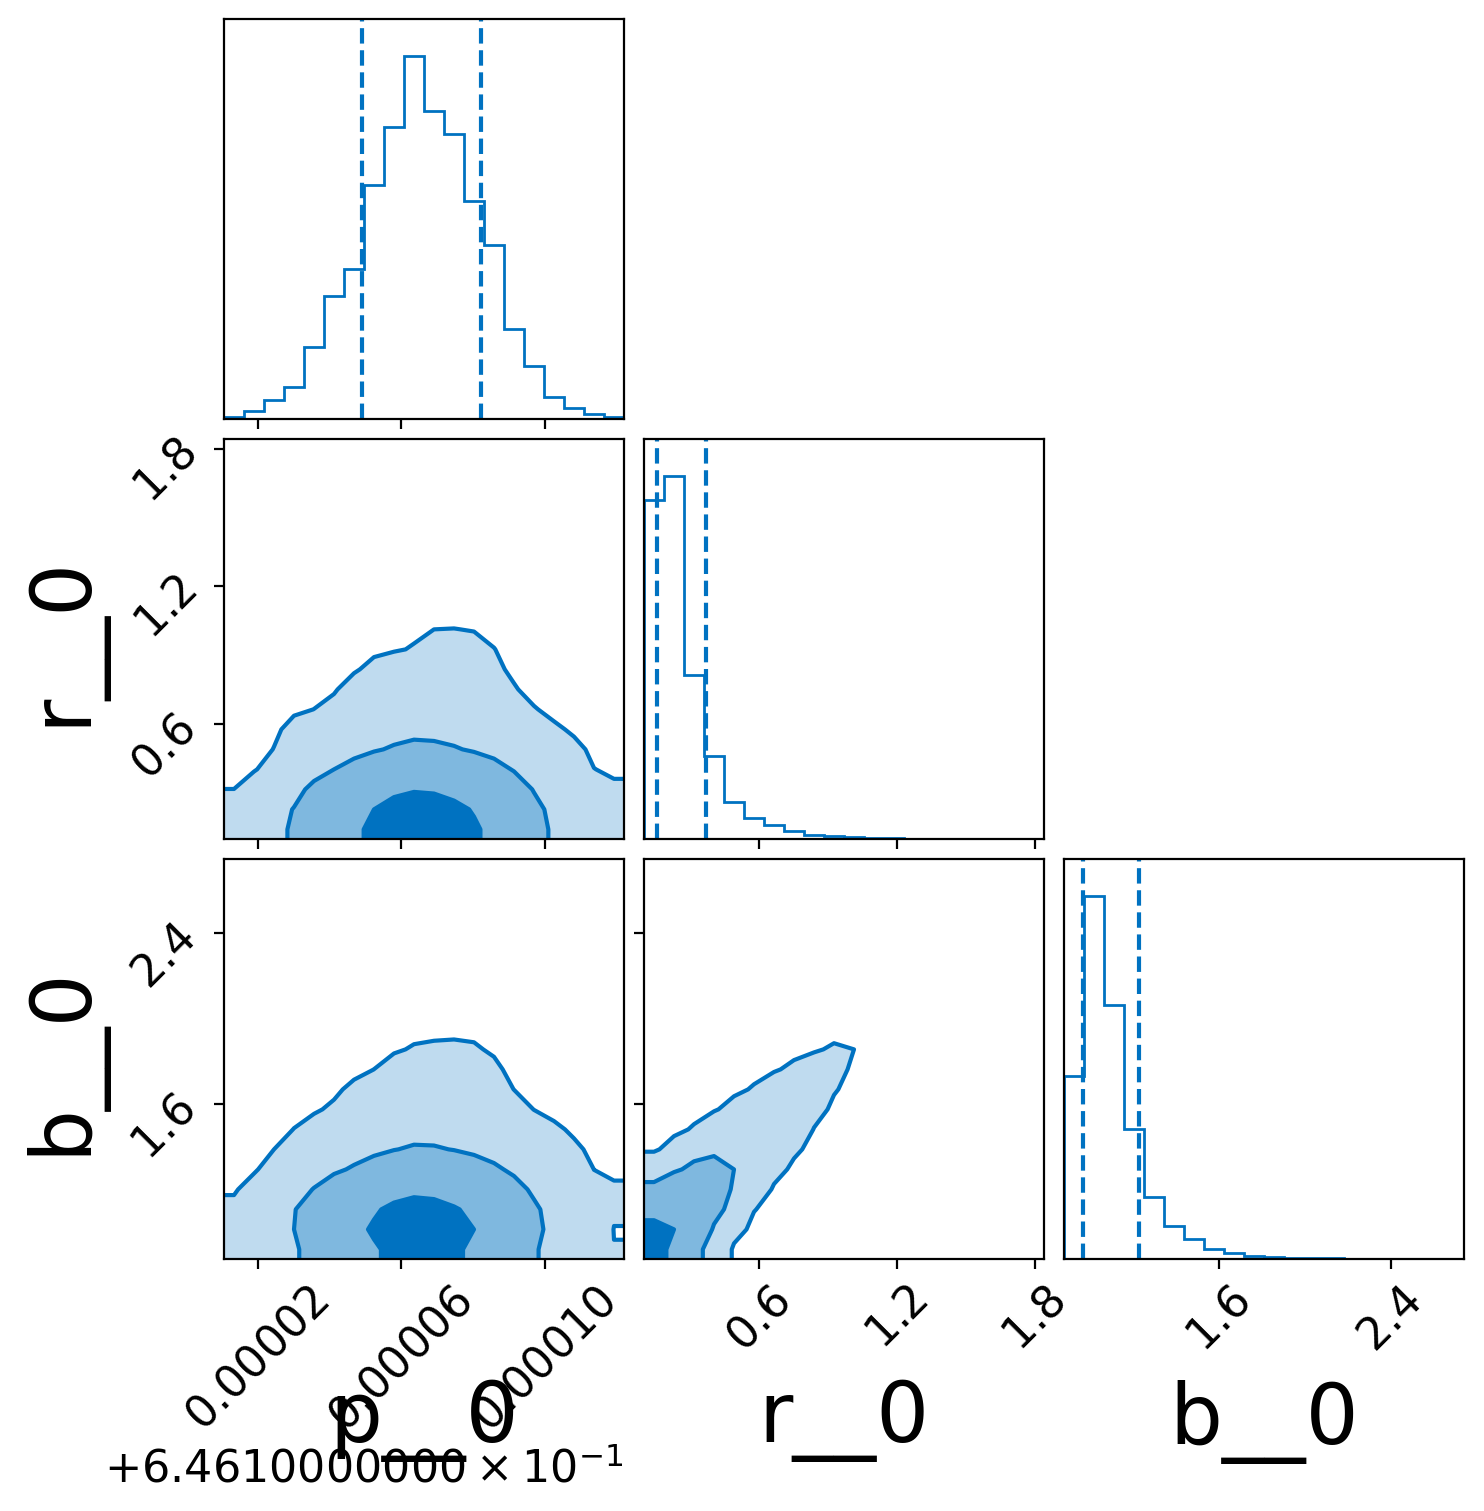

In [17]:
plot_posteriors(tic_entry, trace)


We can also plot the best-fitting light-curve model

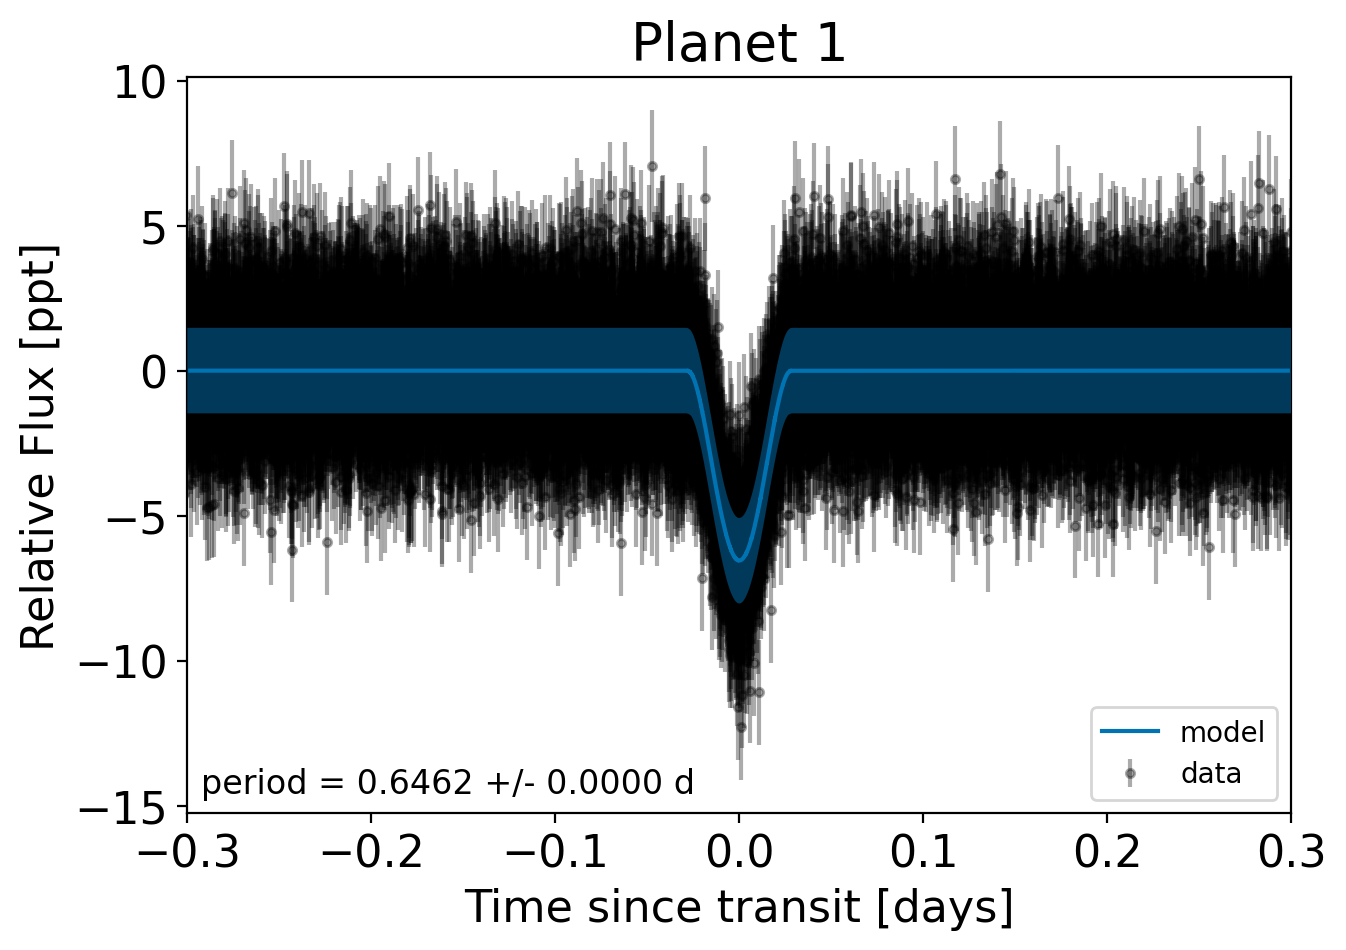

In [18]:
plot_phase(tic_entry, trace)


### Post-processing: Eccentricity

As discussed above, we fit this model assuming a circular orbit which speeds things up for a few reasons:
1) `e=0` allows simpler orbital dynamics which are more computationally efficient (no need to solve Kepler's equation numerically)

2) There are degeneracies between eccentricity, arrgument of periasteron, impact parameter, and planet radius. Hence by setting `e=0` and using the duration in calculating the planet's orbit, the sampler can perform better.

To first order, the eccentricity mainly just changes the transit duration.
This can be thought of as a change in the impled density of the star.
Therefore, if the transit is fit using stellar density (or duration, in this case) as one of the parameters, it is possible to make an independent measurement of the stellar density, and in turn infer the eccentricity of the orbit as a post-processing step.
The details of this eccentricity calculation method are described in [Dawson & Johnson (2012)].

[Dawson & Johnson (2012)]: https://arxiv.org/abs/1203.5537
Note: a different stellar density parameter is required for each planet (if there is more than one planet)

2021-09-11 21:50:07,431 - TESS-ATLAS - INFO - rho_star = 0.592522 ± 0.128203


INFO:TESS-ATLAS:rho_star = 0.592522 ± 0.128203


INFO:root:e[0] = 0.21 + 0.32 - 0.14


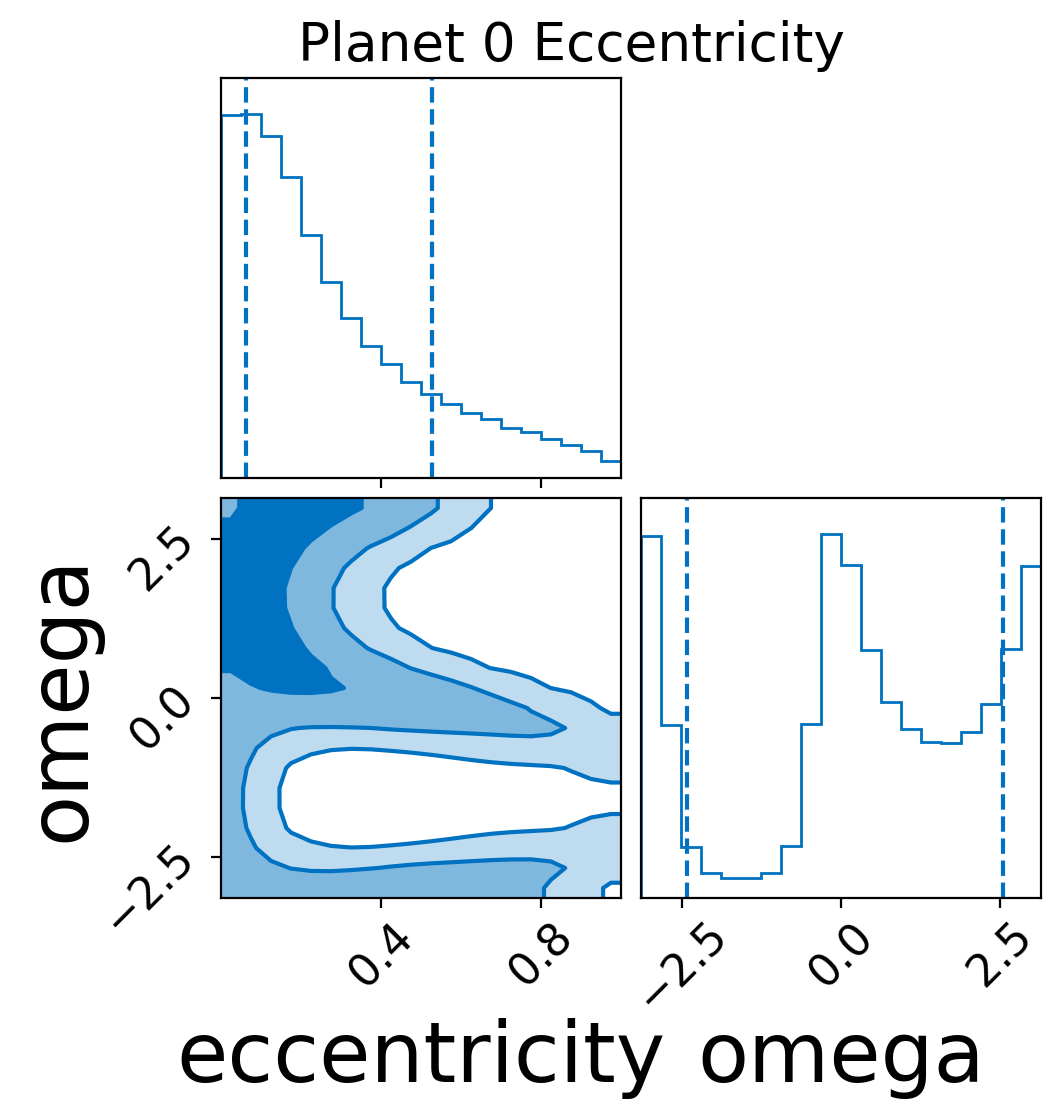

In [19]:
ecc_samples = calculate_eccentricity_weights(tic_entry, trace)
ecc_samples.to_csv(os.path.join(tic_entry.outdir, "eccentricity_samples.csv"))
plot_eccentricity_posteriors(tic_entry, ecc_samples)

## Citations


In [20]:
with planet_transit_model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{celerite2:foremanmackey17, celerite2:foremanmackey18,
exoplanet:agol20, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [21]:
print("\n".join(bib.splitlines()) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Timothy D. Brandt and
            Tom Barclay and Luke Bouma},
   title = {exoplanet-dev/exoplanet v0.4.0},
   month = oct,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
  

### Packages used:


In [22]:
import pkg_resources

dists = [str(d).replace(" ", "==") for d in pkg_resources.working_set]
for i in dists:
    print(i)

zipp==3.4.1
xarray==0.16.1
wxPython==4.0.7.post2
wrapt==1.12.1
widgetsnbextension==3.5.1
wheel==0.36.2
Werkzeug==1.0.1
WebTest==2.0.35
websocket-client==0.59.0
WebOb==1.8.6
webencodings==0.5.1
wcwidth==0.2.5
waitress==1.4.4
vtk==9.0.1
virtualenv==20.0.34
urllib3==1.25.10
uncertainties==3.1.4
typing-extensions==3.7.4.3
typer==0.3.2
traitlets==5.0.5
tqdm==4.62.2
tornado==6.1
toolz==0.10.0
toml==0.10.1
threadpoolctl==2.1.0
Theano==1.0.5
texttable==1.6.3
text-unidecode==1.3
testpath==0.4.4
testbook==0.2.3
terminado==0.9.1
termcolor==1.1.0
tensorflow==2.4.1
tensorflow-estimator==2.4.0
tensorboard==2.4.1
tensorboard-plugin-wit==1.8.0
tempdir==0.7.1
tabulate==0.8.9
sympy==1.8
surfinBH==1.1.5
sphinxcontrib-serializinghtml==1.1.4
sphinxcontrib-qthelp==1.0.3
sphinxcontrib-jsmath==1.0.1
sphinxcontrib-htmlhelp==1.0.3
sphinxcontrib-devhelp==1.0.2
sphinxcontrib-applehelp==1.0.2
Sphinx==3.3.1
sphinx-tabs==1.3.0
sphinx-rtd-theme==0.5.0
sphinx-argparse==0.2.5
soupsieve==2.0.1
sortedcontainers==2.2.2
sn